In [1]:
from tensorflow import keras
from utils import load_meters_data, prepare_data, load_and_prepare_building_dfs
import matplotlib.pyplot as plt
import numpy as np

time_steps = 24
meters_data = load_meters_data('data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls')
X_train = prepare_data(meters_data, time_steps=time_steps, split_ratio=0)
channels = X_train.shape[2]
model = keras.models.load_model('../autoencoder24_4')

plt.rcParams.update({'figure.figsize':(9,4), 'figure.dpi':100})

(43825, 24, 368)
(43825, 368)
(43825, 368)


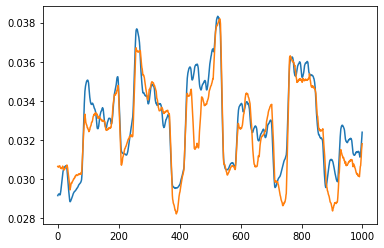

In [47]:
pred = model.predict(X_train)
print(pred.shape)
pred_mean = np.mean(pred, axis=1)
print(pred_mean.shape)
real_mean = np.mean(X_train, axis=1)
print(real_mean.shape)
plt.plot(pred_mean[:1000,0])
plt.plot(real_mean[:1000,0])
plt.show()

In [62]:
copy1 = meters_data.copy()
copy2 = meters_data.copy()
copy1 = copy1.iloc[:-time_steps+1]
copy2 = copy2.iloc[:-time_steps+1]

# replace content of copy with predicted values
print(pred_mean.shape)
print(real_mean.shape)
print(copy1.shape)
copy1.iloc[:] = pred_mean
copy2.iloc[:] = real_mean

(43825, 368)
(43825, 368)
(43825, 368)


In [63]:
predicted_buildings = load_and_prepare_building_dfs(vis_path="data/VIS Målere.xlsx", raw_esave_table=copy1)
actual_buildings = load_and_prepare_building_dfs(vis_path="data/VIS Målere.xlsx", raw_esave_table=copy2)

Data loaded in 0.4141101837158203 seconds
Data loaded in 0.4454047679901123 seconds


Trondheim Kommune - Lade Idrettsanlegg
MSE: 2.4290875084293613


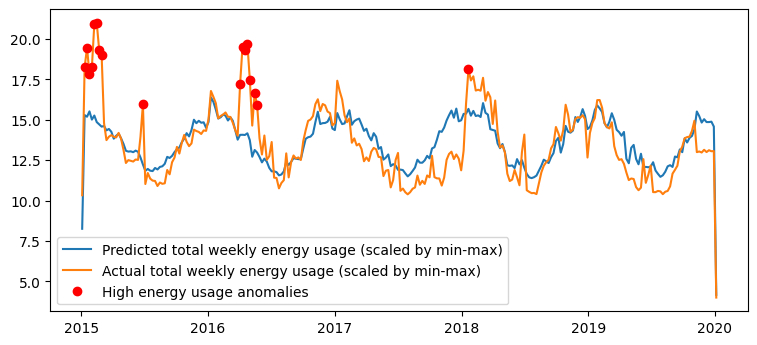

In [171]:
# get random building
test_predicted_building = list(predicted_buildings.keys())[19]
test_predicted_building_df = predicted_buildings[test_predicted_building].copy()
# sum energy usage for a week
test_predicted_building_df = test_predicted_building_df.resample('W').sum()
actual_building_df = actual_buildings[test_predicted_building].resample('W').sum()
# calculate mse
building_mse = np.mean((test_predicted_building_df.iloc[:,-1] - actual_building_df.iloc[:,-1])**2)
print(test_predicted_building)
print(f"MSE: {building_mse}")
# find all points in time when there is an anomaly
anomaly_indices = np.where((actual_building_df.iloc[:,-1] - test_predicted_building_df.iloc[:,-1]) > np.sqrt(building_mse*2))[0] # add np.abs for finding less energy usages anomalies too
# plot both buildings
plt.plot(test_predicted_building_df.iloc[:,-1], label='Predicted total weekly energy usage (scaled by min-max)')
plt.plot(actual_building_df.iloc[:,-1], label='Actual total weekly energy usage (scaled by min-max)')
plt.plot(actual_building_df.iloc[anomaly_indices,-1], 'ro', label='High energy usage anomalies')
plt.legend()
plt.show()